Deep Learning Assignment 2 Pujan

code reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [2]:

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
from torchvision import models
import datetime
import time
import pandas as pd
from torchsummary import summary


In [3]:

def get_device():
    return torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# print("Device is ",get_device())

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def get_output_width(input_width, filter_size, padding, stride):
    return ((input_width - filter_size + 2 * padding)/stride) + 1

print(get_output_width(input_width = 32, filter_size = 5, padding = 0, stride = 1))


28.0


In [7]:

class NetworkBase(nn.Module):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size = 32, print_interim_data_shapes=False):
        super().__init__()
        torch.manual_seed(5)
        self.train_results = []
        self.epoch_number = 0
        self.print_interim_data_shapes = print_interim_data_shapes
    
        transform = transforms.Compose(
            [
                
                # uncomment for data augmentation experiment
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(15),
                transforms.Grayscale(num_output_channels=3), # with grayscale, overfitting slightly decreased, this should be the result of data augmentation, this is not converting all images to grayscale
                # data augmentation ends here
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

        if data_set_name == "cifar_10":
            dataset = torchvision.datasets.CIFAR10(root=download_path, train=True, download=True, transform=transform)
            print('Length of Dataset ', len(dataset))

            train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_data_size, validation_data_size])
            print('Length of Train set ', len(train_dataset))
            print('Length of Val set ', len(val_dataset))
            self.trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
            self.valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

            testset = torchvision.datasets.CIFAR10(root=download_path, train=False, download=True, transform=transform)
            print('Length of Testset ', len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

            self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        
    def display_input_images(self, number_of_images):
        # get some random training images
        dataiter = iter(self.trainloader)
        images, labels = dataiter.next()

        # show images
        imshow(torchvision.utils.make_grid(images))
        # print labels
        print(' '.join(f'{self.classes[labels[j]]:5s}' for j in range(number_of_images)))

    def display_ground_truth_images(self, number_of_images):
        dataiter = iter(self.testloader)
        images, labels = dataiter.next()

        # print images
        imshow(torchvision.utils.make_grid(images))
        print('GroundTruth: ', ' '.join(f'{self.classes[labels[j]]:5s}' for j in range(4)))


    def train_network(self, epoch_number, learning_rate, momentum, optimizer_name):
        self.train()
        optimizer = optim.SGD(self.parameters(), lr= learning_rate, momentum=momentum)
        if optimizer_name == "adam":
            print('using adam optimizer')
            optimizer = optim.Adam(self.parameters(), lr = learning_rate)

        if optimizer_name == "sgd_without_momentum":
            print('using sgd without momentum')
            optimizer = optim.SGD(self.parameters(), lr= learning_rate)

        self.epoch_number = epoch_number
        train_results = []

        for epoch in range(epoch_number):  # loop over the dataset multiple times
            # Training phase
            for i, train_data in enumerate(self.trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                train_inputs, train_labels = train_data[0].to(get_device()), train_data[1].to(get_device())
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                train_outputs = self(train_inputs)
                train_loss = self.criterion(train_outputs, train_labels)
                train_loss.backward()
                optimizer.step()
                
            train_accuracy, train_loss_value = self.get_accuracy_and_loss(self.trainloader)

            val_accuracy, val_loss_value = self.get_accuracy_and_loss(self.valloader)

            train_result = {'epoch': epoch, 'train_loss': train_loss_value, 'train_accuracy': train_accuracy, 
                                  'val_loss': val_loss_value, 'val_accuracy': val_accuracy}
            print('Train result ', train_result)
            train_results.append(train_result)

        print('Finished Training')
        self.train_results = train_results
        return train_results

    def plot_loss_and_accuracy_curves(self):
        epoch_numbers = range(self.epoch_number)
        # loss curves : train / val
        # accuracy curves: train / val
 
        # accuracy curve    
        train_accuracies = [x['train_accuracy'] for x in self.train_results]
        val_accuracies = [x['val_accuracy'] for x in self.train_results]    
        plt.plot(train_accuracies, label="train")
        plt.plot(val_accuracies, label="val")
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title("Accuracy vs Epoch")
        plt.show()

        # Loss curve    
        train_losses = [x['train_loss'] for x in self.train_results]
        val_losses = [x['val_loss'] for x in self.train_results]    
        plt.plot(train_losses, label="train")
        plt.plot(val_losses, label="val")
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title("Loss vs Epoch")
        plt.show()

    def predictions(self, input_images):
        outputs = self(input_images)
        _, predicted = torch.max(outputs, 1)
        print('Predicted: ', ' '.join(f'{self.classes[predicted[j]]:5s}' for j in range(4)))

    def get_accuracy_score(self, outputs, labels):
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        return correct

    def get_accuracy_and_loss(self, data_loader):
        self.eval()
        accuracies = []
        loss_values = []
        total_label_size = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in data_loader:
                # images, labels = data
                images, labels = data[0].to(get_device()), data[1].to(get_device())
                # calculate outputs by running images through the network
                outputs = self(images)
                # the class with the highest energy is what we choose as prediction
                # TODO: find top-k accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_label_size += labels.size(0)
                accuracy_item = (predicted == labels).sum().item()
                accuracies.append(accuracy_item)

                # losses
                loss = self.criterion(outputs, labels)
                loss_item = loss.item()
                loss_values.append(loss_item)
        
        accuracy_score = 100 * np.sum(accuracies) / total_label_size
        loss_value = np.mean(loss_values)
        return (accuracy_score, loss_value)

    def accuracy_in_each_class(self):
    # prepare to count predictions for each class
        correct_pred = {classname: 0 for classname in self.classes}
        total_pred = {classname: 0 for classname in self.classes}

        # again no gradients needed
        with torch.no_grad():
            for data in self.testloader:
                # images, labels = data
                images, labels = data[0].to(get_device()), data[1].to(get_device())
                outputs = self(images)
                _, predictions = torch.max(outputs, 1)
                # collect the correct predictions for each class
                for label, prediction in zip(labels, predictions):
                    if label == prediction:
                        correct_pred[self.classes[label]] += 1
                    total_pred[self.classes[label]] += 1

        # print accuracy for each class
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    




In [8]:
class CnnNetworkOneConvAndOneFc(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size = 32, print_interim_data_shapes = False):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size, print_interim_data_shapes)
        self.criterion = criterion
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 15 * 15, 10)
       
    def forward(self, x):
        if self.print_interim_data_shapes:
            print("Initial x shape ", x.shape)
       
        # First layer
        x = self.conv1(x)
        x = F.relu(x)
        if self.print_interim_data_shapes:
            print('After conv1, shape of x is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 1, shape of x is ', x.shape)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        if self.print_interim_data_shapes:
            print('After flatten, x shape ', x.shape)

        x = self.fc1(x)
        if self.print_interim_data_shapes:
            print('At End, x shape ', x.shape)
            # uncomment_this_to_break_code_here_to_see_the_shapes_of_cnn_for_first_layer
        return x



In [ ]:
criterion = nn.CrossEntropyLoss()

cnn_network_with_one_conv_and_one_fc = CnnNetworkOneConvAndOneFc(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
cnn_network_with_one_conv_and_one_fc = cnn_network_with_one_conv_and_one_fc.to(get_device())

summary(cnn_network_with_one_conv_and_one_fc, (3, 32, 32))

Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Linear-3                   [-1, 10]          72,010
Total params: 72,906
Trainable params: 72,906
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.27
Params size (MB): 0.28
Estimated Total Size (MB): 0.56
----------------------------------------------------------------


In [9]:
# Experiment One Convolution layer (32 3*3 filters) and One Fully Connected Layer
start_time = datetime.datetime.now()
print("start time ", start_time)

lr_results = []
epoch_number = 5
for lr in [0.001, 0.0001, 0.00001]:
    print('learning rate is ', lr)
    # your code here  
    criterion = nn.CrossEntropyLoss()

    cnn_network_with_one_conv_and_one_fc = CnnNetworkOneConvAndOneFc(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
    cnn_network_with_one_conv_and_one_fc = cnn_network_with_one_conv_and_one_fc.to(get_device())

    train_results_with_one_conv_and_one_fc = cnn_network_with_one_conv_and_one_fc.train_network(epoch_number = epoch_number, 
        learning_rate = lr, momentum = 0.9, optimizer_name = "sgd")
    cnn_network_with_one_conv_and_one_fc.plot_loss_and_accuracy_curves()
    
    end_time =  datetime.datetime.now()
    print("end time ", end_time)
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    print(difference_total_seconds)

    last_train_data = [td for td in train_results_with_one_conv_and_one_fc if td['epoch'] == epoch_number - 1][0]
   
    lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})


start time  2022-10-27 10:05:31.761314
learning rate is  0.001


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


KeyboardInterrupt: ignored

# Analysis:
In terms of experiments in 3 learning rate, the highest accuracy was for lr = 0.001. Though it has highest overfitting, we will choose this learning rate, as we shall refine our model to resolve overfitting.

In [10]:
# Add Another conv layer
class CnnNetworkTwoConvAndOneFc(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size = 32, print_interim_data_shapes = False):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size, print_interim_data_shapes)
        self.criterion = criterion
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 6 * 6, 10)
       
    def forward(self, x):
        if self.print_interim_data_shapes:
            print("Initial x shape ", x.shape)
       
        # First layer
        x = self.conv1(x)
        x = F.relu(x)
        if self.print_interim_data_shapes:
            print('After conv1, shape of x is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 1, shape of x is ', x.shape)

        x = self.conv2(x)
        x = F.relu(x)
        if self.print_interim_data_shapes:
            print('After conv2, shape of x is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 2, shape of x is ', x.shape)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        if self.print_interim_data_shapes:
            print('After flatten, x shape ', x.shape)

        x = self.fc1(x)
        if self.print_interim_data_shapes:
            print('At End, x shape ', x.shape)
            break_here_to_see_shapes_for_first_iter
        return x



start time  2022-10-25 14:45:37.477299
learning rate is  0.001
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 1.1457318808563053, 'train_accuracy': 60.27, 'val_loss': 1.1963710028350354, 'val_accuracy': 58.09}
Train result  {'epoch': 1, 'train_loss': 0.9506039722855203, 'train_accuracy': 67.0275, 'val_loss': 1.043430791194737, 'val_accuracy': 63.92}
Train result  {'epoch': 2, 'train_loss': 0.8087874571234919, 'train_accuracy': 72.5425, 'val_loss': 0.9440283214543015, 'val_accuracy': 67.39}
Train result  {'epoch': 3, 'train_loss': 0.7811376230022404, 'train_accuracy': 73.42, 'val_loss': 0.9674151953605935, 'val_accuracy': 66.98}
Train result  {'epoch': 4, 'train_loss': 0.69900637330967, 'train_accuracy': 76.265, 'val_loss': 0.9288549172084779, 'val_accuracy': 68.16}
Finished Training


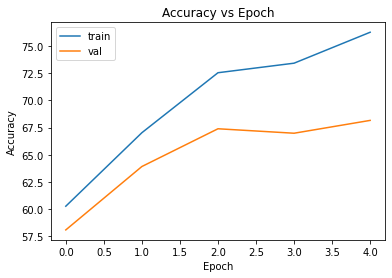

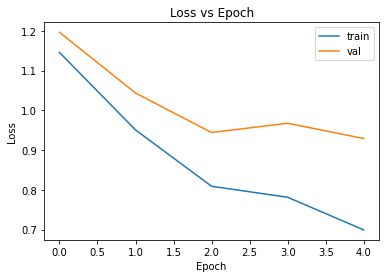

end time  2022-10-25 14:51:56.888157
379.410858


In [ ]:
# Experiment Two Convolution layer (32 3*3 filters) and One Fully Connected Layer
start_time = datetime.datetime.now()
print("start time ", start_time)

lr_results = []
epoch_number = 5
for lr in [0.001]:
    print('learning rate is ', lr)
    # your code here  
    criterion = nn.CrossEntropyLoss()

    cnn_network_with_two_conv_and_one_fc = CnnNetworkTwoConvAndOneFc(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
    cnn_network_with_two_conv_and_one_fc = cnn_network_with_two_conv_and_one_fc.to(get_device())

    train_results_with_two_conv_and_one_fc = cnn_network_with_two_conv_and_one_fc.train_network(epoch_number = epoch_number, 
        learning_rate = lr, momentum = 0.9, optimizer_name = "sgd")
    cnn_network_with_two_conv_and_one_fc.plot_loss_and_accuracy_curves()
    
    end_time =  datetime.datetime.now()
    print("end time ", end_time)
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    print(difference_total_seconds)

    last_train_data = [td for td in train_results_with_two_conv_and_one_fc if td['epoch'] == epoch_number - 1][0]
   
    lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})


In [ ]:
criterion = nn.CrossEntropyLoss()

cnn_network_with_two_conv_and_one_fc = CnnNetworkTwoConvAndOneFc(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
            train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
cnn_network_with_two_conv_and_one_fc = cnn_network_with_two_conv_and_one_fc.to(get_device())
summary(cnn_network_with_two_conv_and_one_fc, (3, 32, 32))

Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 13, 13]          18,496
         MaxPool2d-4             [-1, 64, 6, 6]               0
            Linear-5                   [-1, 10]          23,050
Total params: 42,442
Trainable params: 42,442
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.37
Params size (MB): 0.16
Estimated Total Size (MB): 0.55
----------------------------------------------------------------


In [11]:
# Add Another conv layer
class CnnNetworkThreeConvAndOneFc(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size = 32, print_interim_data_shapes = False):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size, print_interim_data_shapes)
        self.criterion = criterion
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 25, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(25 * 2 * 2, 10)
       
    def forward(self, x):
        if self.print_interim_data_shapes:
            print("Initial x shape ", x.shape)
       
        # First layer
        x = self.conv1(x)
        x = F.relu(x)
        if self.print_interim_data_shapes:
            print('After conv1, shape of x is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 1, shape of x is ', x.shape)

        # Second Layer
        x = self.conv2(x)
        x = F.relu(x)
        if self.print_interim_data_shapes:
            print('After conv2, shape of x is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 2, shape of x is ', x.shape)
        
        # Third Layer
        x = self.conv3(x)
        x = F.relu(x)
        if self.print_interim_data_shapes:
            print('After conv3, shape of x is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 3, shape of x is ', x.shape)

        # FC layer
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        if self.print_interim_data_shapes:
            print('After flatten, x shape ', x.shape)

        x = self.fc1(x)
        if self.print_interim_data_shapes:
            print('At End, x shape ', x.shape)
            break_here_to_see_shapes_for_first_iter
        return x



start time  2022-10-26 16:15:21.287569
learning rate is  0.001


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 1.408456179265678, 'train_accuracy': 49.1925, 'val_loss': 1.4270345656752585, 'val_accuracy': 47.94}
Train result  {'epoch': 1, 'train_loss': 1.0984173547409475, 'train_accuracy': 61.515, 'val_loss': 1.1418104543745518, 'val_accuracy': 59.73}
Train result  {'epoch': 2, 'train_loss': 0.9728453753564507, 'train_accuracy': 65.4625, 'val_loss': 1.0540240366742015, 'val_accuracy': 62.83}
Train result  {'epoch': 3, 'train_loss': 0.8913171377805993, 'train_accuracy': 68.935, 'val_loss': 0.995881579541415, 'val_accuracy': 65.73}
Train result  {'epoch': 4, 'train_loss': 0.8610775032078382, 'train_accuracy': 69.8075, 'val_loss': 0.9984405301108956, 'val_accuracy': 65.52}
Finished Training


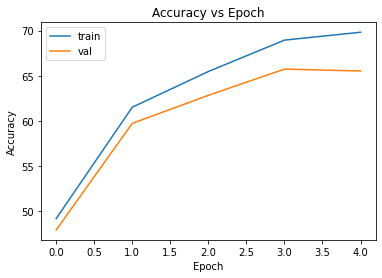

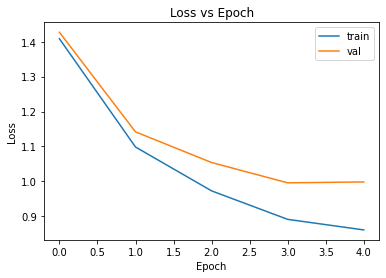

end time  2022-10-26 16:22:40.044238
438.756669
learning rate is  0.0001
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 1.985124050986767, 'train_accuracy': 28.6175, 'val_loss': 1.9918428815364837, 'val_accuracy': 28.29}
Train result  {'epoch': 1, 'train_loss': 1.7405371637284757, 'train_accuracy': 36.7775, 'val_loss': 1.7526121111392974, 'val_accuracy': 36.15}
Train result  {'epoch': 2, 'train_loss': 1.577700426581502, 'train_accuracy': 41.9375, 'val_loss': 1.5864233157157899, 'val_accuracy': 41.13}
Train result  {'epoch': 3, 'train_loss': 1.5026642881780863, 'train_accuracy': 44.7725, 'val_loss': 1.5137808309435845, 'val_accuracy': 43.7}
Train result  {'epoch': 4, 'train_loss': 1.440159532161057, 'train_accuracy': 48.1325, 'val_loss': 1.455328312432766, 'val_accuracy': 47.16}
Finished Training


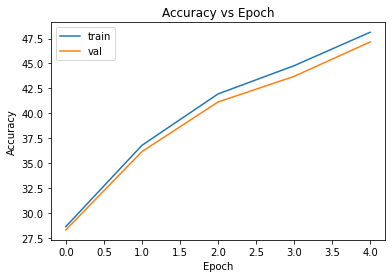

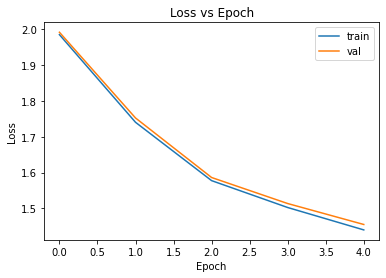

end time  2022-10-26 16:29:40.513876
859.226307
learning rate is  1e-05
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 2.3007247160196305, 'train_accuracy': 11.185, 'val_loss': 2.299751178741455, 'val_accuracy': 11.56}
Train result  {'epoch': 1, 'train_loss': 2.2947199192762375, 'train_accuracy': 14.8575, 'val_loss': 2.2940986615180967, 'val_accuracy': 15.12}
Train result  {'epoch': 2, 'train_loss': 2.28511346309185, 'train_accuracy': 16.625, 'val_loss': 2.2849036297798158, 'val_accuracy': 16.94}
Train result  {'epoch': 3, 'train_loss': 2.2648228437900544, 'train_accuracy': 17.8675, 'val_loss': 2.2651176849365235, 'val_accuracy': 18.03}
Train result  {'epoch': 4, 'train_loss': 2.221274797999859, 'train_accuracy': 19.0125, 'val_loss': 2.2225553779125216, 'val_accuracy': 18.63}
Finished Training


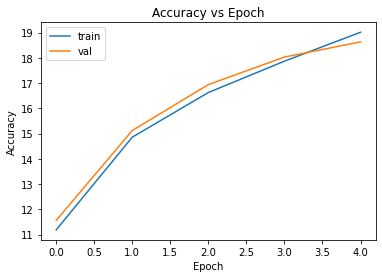

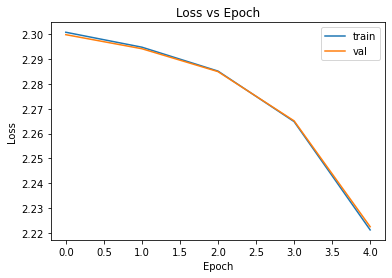

end time  2022-10-26 16:36:35.492564
1274.204995
end time  2022-10-26 16:36:35.492825
1274.205256


In [ ]:
# Experiment Three Convolution layer (32 3*3 filters) and One Fully Connected Layer
start_time = datetime.datetime.now()
print("start time ", start_time)

lr_results = []
epoch_number = 5
for lr in [0.001, 0.0001, 0.00001]:
    print('learning rate is ', lr)
    # your code here  
    criterion = nn.CrossEntropyLoss()

    cnn_network_with_three_conv_and_one_fc = CnnNetworkThreeConvAndOneFc(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
    cnn_network_with_three_conv_and_one_fc = cnn_network_with_three_conv_and_one_fc.to(get_device())

    train_results_with_three_conv_and_one_fc = cnn_network_with_three_conv_and_one_fc.train_network(epoch_number = epoch_number, 
        learning_rate = lr, momentum = 0.9, optimizer_name = "sgd")
    cnn_network_with_three_conv_and_one_fc.plot_loss_and_accuracy_curves()
    
    end_time =  datetime.datetime.now()
    print("end time ", end_time)
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    print(difference_total_seconds)

    last_train_data = [td for td in train_results_with_three_conv_and_one_fc if td['epoch'] == epoch_number - 1][0]
   
    lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)


start time  2022-10-26 16:45:42.994173
learning rate is  0.01
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 1.909917199343443, 'train_accuracy': 30.2075, 'val_loss': 1.9277821157455444, 'val_accuracy': 29.86}
Train result  {'epoch': 1, 'train_loss': 1.8089149225413799, 'train_accuracy': 32.6325, 'val_loss': 1.8406185879945756, 'val_accuracy': 32.1}
Train result  {'epoch': 2, 'train_loss': 1.8474353092193603, 'train_accuracy': 32.045, 'val_loss': 1.8790192712664604, 'val_accuracy': 31.66}
Train result  {'epoch': 3, 'train_loss': 1.8302532697319984, 'train_accuracy': 32.015, 'val_loss': 1.8567249765634537, 'val_accuracy': 31.31}
Train result  {'epoch': 4, 'train_loss': 1.786962272234261, 'train_accuracy': 34.765, 'val_loss': 1.7982266505002975, 'val_accuracy': 34.3}
Finished Training


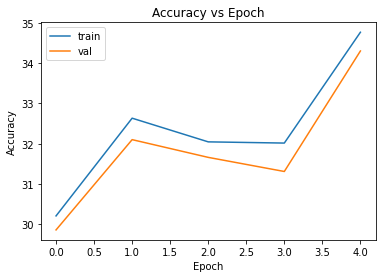

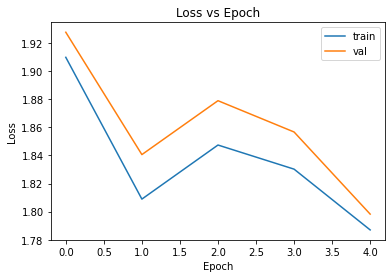

end time  2022-10-26 16:52:35.781929
412.787756
learning rate is  0.002
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 1.330698739592731, 'train_accuracy': 52.585, 'val_loss': 1.3646864938259125, 'val_accuracy': 51.66}
Train result  {'epoch': 1, 'train_loss': 1.061976764413342, 'train_accuracy': 63.4425, 'val_loss': 1.1231736543625592, 'val_accuracy': 61.02}
Train result  {'epoch': 2, 'train_loss': 0.9625271377717145, 'train_accuracy': 66.4575, 'val_loss': 1.0674939699307084, 'val_accuracy': 64.14}
Train result  {'epoch': 3, 'train_loss': 0.8883731048037298, 'train_accuracy': 69.0175, 'val_loss': 1.014454936864972, 'val_accuracy': 65.44}
Train result  {'epoch': 4, 'train_loss': 0.8451462713142625, 'train_accuracy': 70.205, 'val_loss': 1.0115019819654525, 'val_accuracy': 65.53}
Finished Training


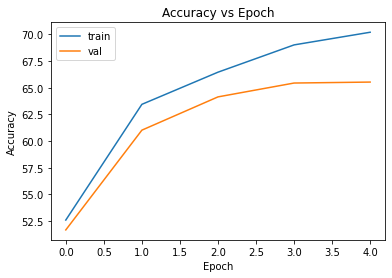

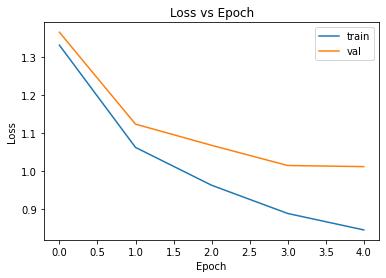

end time  2022-10-26 16:59:28.067062
825.072889
learning rate is  0.003
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 1.3761504681810737, 'train_accuracy': 50.25, 'val_loss': 1.4176525920450687, 'val_accuracy': 48.82}
Train result  {'epoch': 1, 'train_loss': 1.1218250828899443, 'train_accuracy': 60.02, 'val_loss': 1.1900582137554885, 'val_accuracy': 57.62}
Train result  {'epoch': 2, 'train_loss': 1.0146791800126433, 'train_accuracy': 64.6175, 'val_loss': 1.1003084007699042, 'val_accuracy': 61.52}
Train result  {'epoch': 3, 'train_loss': 0.9850645467453636, 'train_accuracy': 65.39, 'val_loss': 1.1221492394432426, 'val_accuracy': 62.18}
Train result  {'epoch': 4, 'train_loss': 0.9696029291930143, 'train_accuracy': 66.1875, 'val_loss': 1.1154302773764357, 'val_accuracy': 62.47}
Finished Training


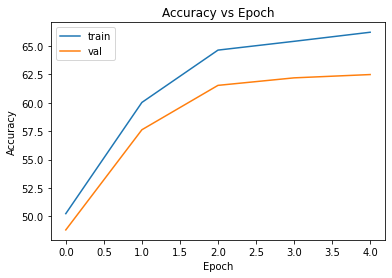

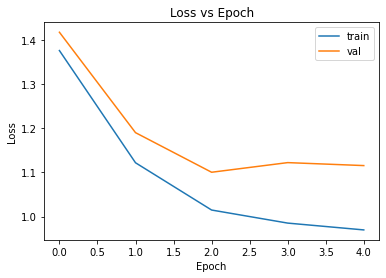

end time  2022-10-26 17:06:14.895422
1231.901249
end time  2022-10-26 17:06:14.895730
1231.901557


In [ ]:
# Experiment Three Convolution layer (32 3*3 filters) and One Fully Connected Layer
start_time = datetime.datetime.now()
print("start time ", start_time)

lr_results = []
epoch_number = 5
for lr in [0.01, 0.002, 0.003]:
    print('learning rate is ', lr)
    # your code here  
    criterion = nn.CrossEntropyLoss()

    cnn_network_with_three_conv_and_one_fc = CnnNetworkThreeConvAndOneFc(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
    cnn_network_with_three_conv_and_one_fc = cnn_network_with_three_conv_and_one_fc.to(get_device())

    train_results_with_three_conv_and_one_fc = cnn_network_with_three_conv_and_one_fc.train_network(epoch_number = epoch_number, 
        learning_rate = lr, momentum = 0.9, optimizer_name = "sgd")
    cnn_network_with_three_conv_and_one_fc.plot_loss_and_accuracy_curves()
    
    end_time =  datetime.datetime.now()
    print("end time ", end_time)
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    print(difference_total_seconds)

    last_train_data = [td for td in train_results_with_three_conv_and_one_fc if td['epoch'] == epoch_number - 1][0]
   
    lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)


start time  2022-10-26 17:16:41.874990
learning rate is  0.002
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
using adam optimizer
Train result  {'epoch': 0, 'train_loss': 1.34119241309762, 'train_accuracy': 51.3475, 'val_loss': 1.373143899023533, 'val_accuracy': 50.0}
Train result  {'epoch': 1, 'train_loss': 1.2825836392857135, 'train_accuracy': 53.605, 'val_loss': 1.3236011818349362, 'val_accuracy': 51.73}
Train result  {'epoch': 2, 'train_loss': 1.1930614126615227, 'train_accuracy': 57.4225, 'val_loss': 1.2390872525840997, 'val_accuracy': 55.43}
Train result  {'epoch': 3, 'train_loss': 1.1829157142326236, 'train_accuracy': 57.62, 'val_loss': 1.2332503811717033, 'val_accuracy': 56.03}
Train result  {'epoch': 4, 'train_loss': 1.1332315093139187, 'train_accuracy': 59.1475, 'val_loss': 1.2002191186331213, 'val_accuracy': 56.99}
Finished Training


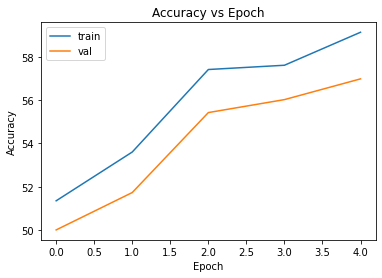

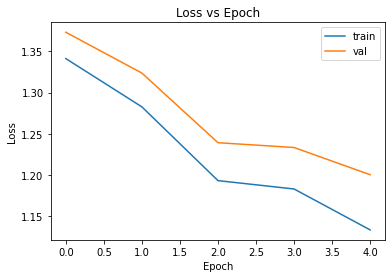

end time  2022-10-26 17:23:58.485864
436.610874
end time  2022-10-26 17:23:58.486180
436.61119


In [ ]:
# Experiment for Adam
start_time = datetime.datetime.now()
print("start time ", start_time)

lr_results = []
epoch_number = 5
for lr in [0.002]:
    print('learning rate is ', lr)
    # your code here  
    criterion = nn.CrossEntropyLoss()

    cnn_network_with_three_conv_and_one_fc = CnnNetworkThreeConvAndOneFc(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
    cnn_network_with_three_conv_and_one_fc = cnn_network_with_three_conv_and_one_fc.to(get_device())

    train_results_with_three_conv_and_one_fc = cnn_network_with_three_conv_and_one_fc.train_network(epoch_number = epoch_number, 
        learning_rate = lr, momentum = 0.9, optimizer_name = "adam")
    cnn_network_with_three_conv_and_one_fc.plot_loss_and_accuracy_curves()
    
    end_time =  datetime.datetime.now()
    print("end time ", end_time)
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    print(difference_total_seconds)

    last_train_data = [td for td in train_results_with_three_conv_and_one_fc if td['epoch'] == epoch_number - 1][0]
   
    lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)


start time  2022-10-26 17:27:31.183691
learning rate is  0.002
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
using sgd without momentum
Train result  {'epoch': 0, 'train_loss': 1.7603360098779202, 'train_accuracy': 35.89, 'val_loss': 1.7711977748394012, 'val_accuracy': 35.74}
Train result  {'epoch': 1, 'train_loss': 1.5184505025118589, 'train_accuracy': 44.565, 'val_loss': 1.528086063158512, 'val_accuracy': 43.86}
Train result  {'epoch': 2, 'train_loss': 1.385935306584835, 'train_accuracy': 50.6525, 'val_loss': 1.4007298078656196, 'val_accuracy': 49.55}
Train result  {'epoch': 3, 'train_loss': 1.3068920925706624, 'train_accuracy': 52.6375, 'val_loss': 1.328679330843687, 'val_accuracy': 51.48}
Train result  {'epoch': 4, 'train_loss': 1.3487351544689388, 'train_accuracy': 52.6675, 'val_loss': 1.3814514913678169, 'val_accuracy': 51.86}
Finished Training


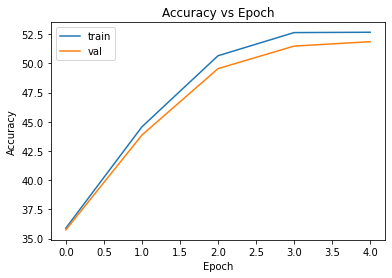

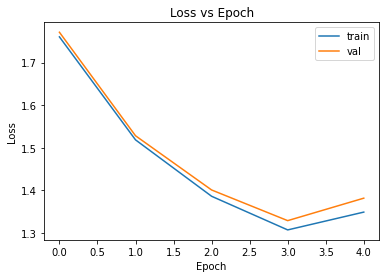

end time  2022-10-26 17:34:11.648186
400.464495
end time  2022-10-26 17:34:11.648472
400.464781


In [ ]:

# Experiment for sgd_without_momentum
start_time = datetime.datetime.now()
print("start time ", start_time)

lr_results = []
epoch_number = 5
for lr in [0.002]:
    print('learning rate is ', lr)
    # your code here  
    criterion = nn.CrossEntropyLoss()

    cnn_network_with_three_conv_and_one_fc = CnnNetworkThreeConvAndOneFc(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
    cnn_network_with_three_conv_and_one_fc = cnn_network_with_three_conv_and_one_fc.to(get_device())

    train_results_with_three_conv_and_one_fc = cnn_network_with_three_conv_and_one_fc.train_network(epoch_number = epoch_number, 
        learning_rate = lr, momentum = 0.9, optimizer_name = "sgd_without_momentum")
    cnn_network_with_three_conv_and_one_fc.plot_loss_and_accuracy_curves()
    
    end_time =  datetime.datetime.now()
    print("end time ", end_time)
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    print(difference_total_seconds)

    last_train_data = [td for td in train_results_with_three_conv_and_one_fc if td['epoch'] == epoch_number - 1][0]
   
    lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)


In [ ]:
criterion = nn.CrossEntropyLoss()
cnn_network_with_three_conv_and_one_fc = CnnNetworkThreeConvAndOneFc(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
cnn_network_with_three_conv_and_one_fc = cnn_network_with_three_conv_and_one_fc.to(get_device())

summary(cnn_network_with_three_conv_and_one_fc, (3, 32, 32))

Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 13, 13]          18,496
         MaxPool2d-4             [-1, 64, 6, 6]               0
            Conv2d-5             [-1, 25, 4, 4]          14,425
         MaxPool2d-6             [-1, 25, 2, 2]               0
            Linear-7                   [-1, 10]           1,010
Total params: 34,827
Trainable params: 34,827
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.38
Params size (MB): 0.13
Estimated Total Size (MB): 

Accuracy decreased for 3 conv layer, So stick with 2 conv layer. It has overfitting, so let's try resolving overfitting
Method 1: Batch Norm
Method 2: Data augmentation


In [14]:
# Experiment to limit overfitting: BatchNorm:
class CnnNetworkThreeConvAndOneFcAndBatchNorm(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size = 32, print_interim_data_shapes = False):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size, print_interim_data_shapes)
        self.criterion = criterion
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 25, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(25 * 2 * 2, 10)
       
    def forward(self, x):
        if self.print_interim_data_shapes:
            print("Initial x shape ", x.shape)
       
        # First layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv1_bn(x)
        if self.print_interim_data_shapes:
            print('After conv1, shape of x is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 1, shape of x is ', x.shape)

        # Second Layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv2_bn(x)
        if self.print_interim_data_shapes:
            print('After conv2, shape of x is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 2, shape of x is ', x.shape)
        
        # Third Layer
        x = self.conv3(x)
        x = F.relu(x)
        if self.print_interim_data_shapes:
            print('After conv3, shape of x is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 3, shape of x is ', x.shape)

        # FC layer
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        if self.print_interim_data_shapes:
            print('After flatten, x shape ', x.shape)

        x = self.fc1(x)
        if self.print_interim_data_shapes:
            print('At End, x shape ', x.shape)
            break_here_to_see_shapes_for_first_iter
        return x



start time  2022-10-27 01:07:56.822104
learning rate is  0.002


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 1.3509288283884526, 'train_accuracy': 52.125, 'val_loss': 1.3870433908164501, 'val_accuracy': 50.43}
Train result  {'epoch': 1, 'train_loss': 1.0833441756110638, 'train_accuracy': 62.2075, 'val_loss': 1.149186868110299, 'val_accuracy': 60.14}
Train result  {'epoch': 2, 'train_loss': 1.0062749507235362, 'train_accuracy': 64.73, 'val_loss': 1.0996722531929612, 'val_accuracy': 61.6}
Train result  {'epoch': 3, 'train_loss': 0.9651327839845791, 'train_accuracy': 66.57, 'val_loss': 1.0932046113785356, 'val_accuracy': 62.96}
Train result  {'epoch': 4, 'train_loss': 0.914445969065791, 'train_accuracy': 68.06, 'val_loss': 1.0548748485818504, 'val_accuracy': 64.21}
Finished Training


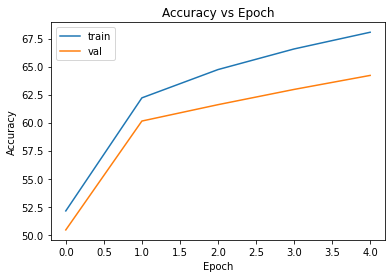

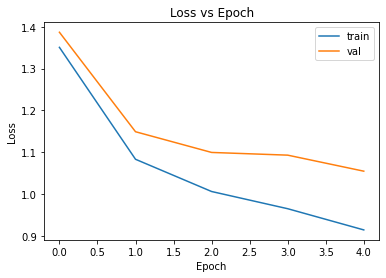

end time  2022-10-27 01:15:26.663453
449.841349
end time  2022-10-27 01:15:26.664326
449.842222


In [ ]:

# Experiment for Batch Norm to limit overfitting
start_time = datetime.datetime.now()
print("start time ", start_time)

lr_results = []
epoch_number = 5
for lr in [0.002]:
    print('learning rate is ', lr)
    # your code here  
    criterion = nn.CrossEntropyLoss()

    cnn_network_with_three_conv_and_one_fc_batch_norm = CnnNetworkThreeConvAndOneFcAndBatchNorm(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
    cnn_network_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.to(get_device())

    train_results_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.train_network(epoch_number = epoch_number, 
        learning_rate = lr, momentum = 0.9, optimizer_name = "sgd")
    cnn_network_with_three_conv_and_one_fc_batch_norm.plot_loss_and_accuracy_curves()
    
    end_time =  datetime.datetime.now()
    print("end time ", end_time)
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    print(difference_total_seconds)

    last_train_data = [td for td in train_results_with_three_conv_and_one_fc_batch_norm if td['epoch'] == epoch_number - 1][0]
   
    lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)


start time  2022-10-27 01:37:04.333769
learning rate is  0.002
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 1.3813852724760771, 'train_accuracy': 51.235, 'val_loss': 1.4330353718996047, 'val_accuracy': 49.53}
Train result  {'epoch': 1, 'train_loss': 1.1458596824802458, 'train_accuracy': 60.1975, 'val_loss': 1.2082931788146496, 'val_accuracy': 57.41}
Train result  {'epoch': 2, 'train_loss': 1.1458136645048858, 'train_accuracy': 60.4075, 'val_loss': 1.2305654418230056, 'val_accuracy': 57.57}
Train result  {'epoch': 3, 'train_loss': 0.9912760754174553, 'train_accuracy': 65.8875, 'val_loss': 1.1098248556111008, 'val_accuracy': 62.01}
Train result  {'epoch': 4, 'train_loss': 0.994582865997497, 'train_accuracy': 65.7775, 'val_loss': 1.1429999562591315, 'val_accuracy': 61.68}
Finished Training


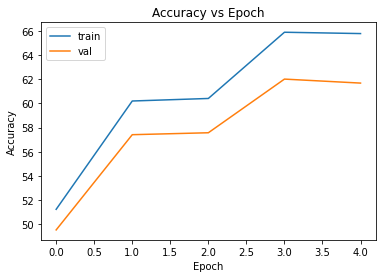

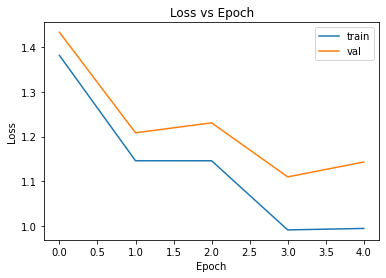

end time  2022-10-27 01:44:54.786522
470.452753
end time  2022-10-27 01:44:54.786855
470.453086


In [ ]:

# Experiment for Data augmentation to limit overfitting, grayscale
start_time = datetime.datetime.now()
print("start time ", start_time)

lr_results = []
epoch_number = 5
for lr in [0.002]:
    print('learning rate is ', lr)
    # your code here  
    criterion = nn.CrossEntropyLoss()

    cnn_network_with_three_conv_and_one_fc_batch_norm = CnnNetworkThreeConvAndOneFcAndBatchNorm(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
    cnn_network_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.to(get_device())

    train_results_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.train_network(epoch_number = epoch_number, 
        learning_rate = lr, momentum = 0.9, optimizer_name = "sgd")
    cnn_network_with_three_conv_and_one_fc_batch_norm.plot_loss_and_accuracy_curves()
    
    end_time =  datetime.datetime.now()
    print("end time ", end_time)
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    print(difference_total_seconds)

    last_train_data = [td for td in train_results_with_three_conv_and_one_fc_batch_norm if td['epoch'] == epoch_number - 1][0]
   
    lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)


start time  2022-10-27 01:59:05.512967
learning rate is  0.002
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 1.5986197605878114, 'train_accuracy': 41.8775, 'val_loss': 1.60801504778862, 'val_accuracy': 41.25}
Train result  {'epoch': 1, 'train_loss': 1.4007871438398958, 'train_accuracy': 49.85, 'val_loss': 1.4233969110786915, 'val_accuracy': 49.33}
Train result  {'epoch': 2, 'train_loss': 1.3733940025180578, 'train_accuracy': 51.0225, 'val_loss': 1.3993718928217889, 'val_accuracy': 50.34}
Train result  {'epoch': 3, 'train_loss': 1.3007328237585722, 'train_accuracy': 53.2325, 'val_loss': 1.3308340043574571, 'val_accuracy': 52.79}
Train result  {'epoch': 4, 'train_loss': 1.3093640830270945, 'train_accuracy': 53.0325, 'val_loss': 1.3404726630538701, 'val_accuracy': 52.38}
Finished Training


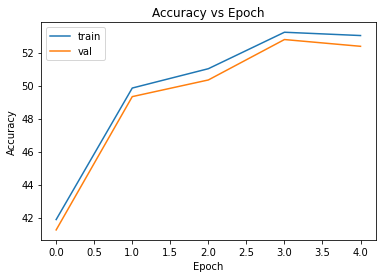

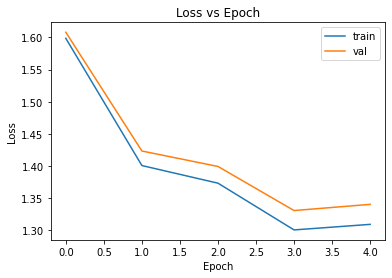

end time  2022-10-27 02:07:08.661744
483.148777
end time  2022-10-27 02:07:08.662053
483.149086


In [ ]:

# Experiment for Data augmentation to limit overfitting
start_time = datetime.datetime.now()
print("start time ", start_time)

lr_results = []
epoch_number = 5
for lr in [0.002]:
    print('learning rate is ', lr)
    # your code here  
    criterion = nn.CrossEntropyLoss()

    cnn_network_with_three_conv_and_one_fc_batch_norm = CnnNetworkThreeConvAndOneFcAndBatchNorm(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
    cnn_network_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.to(get_device())

    train_results_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.train_network(epoch_number = epoch_number, 
        learning_rate = lr, momentum = 0.9, optimizer_name = "sgd")
    cnn_network_with_three_conv_and_one_fc_batch_norm.plot_loss_and_accuracy_curves()
    
    end_time =  datetime.datetime.now()
    print("end time ", end_time)
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    print(difference_total_seconds)

    last_train_data = [td for td in train_results_with_three_conv_and_one_fc_batch_norm if td['epoch'] == epoch_number - 1][0]
   
    lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)


In [15]:
# Experiment to limit overfitting: BatchNorm:
class CnnNetworkThreeConvAndOneFcAndBatchNormAndDropout(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size = 32, print_interim_data_shapes = False):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size, print_interim_data_shapes)
        self.criterion = criterion
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 25, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(25 * 2 * 2, 10)

        self.dropout_2d = nn.Dropout2d()

       
    def forward(self, x):
        if self.print_interim_data_shapes:
            print("Initial x shape ", x.shape)
       
        # First layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv1_bn(x)
        if self.print_interim_data_shapes:
            print('After conv1, shape of x is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 1, shape of x is ', x.shape)

        x = self.dropout_2d(x)

        # Second Layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv2_bn(x)
        if self.print_interim_data_shapes:
            print('After conv2, shape of x is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 2, shape of x is ', x.shape)
        
        x = self.dropout_2d(x)
        # Third Layer
        x = self.conv3(x)
        x = F.relu(x)
        if self.print_interim_data_shapes:
            print('After conv3, shape of x is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 3, shape of x is ', x.shape)

        x = self.dropout_2d(x)
        # FC layer
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        if self.print_interim_data_shapes:
            print('After flatten, x shape ', x.shape)

        x = self.fc1(x)
        if self.print_interim_data_shapes:
            print('At End, x shape ', x.shape)
            break_here_to_see_shapes_for_first_iter
        return x



start time  2022-10-27 02:15:39.273580
learning rate is  0.002
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 2.190516482591629, 'train_accuracy': 17.975, 'val_loss': 2.190628969669342, 'val_accuracy': 17.9}
Train result  {'epoch': 1, 'train_loss': 2.0864830218315125, 'train_accuracy': 22.88, 'val_loss': 2.0944287079811095, 'val_accuracy': 22.8}
Train result  {'epoch': 2, 'train_loss': 2.0085603695869447, 'train_accuracy': 26.1875, 'val_loss': 2.018003998470306, 'val_accuracy': 25.65}
Train result  {'epoch': 3, 'train_loss': 1.9961377872228623, 'train_accuracy': 27.2425, 'val_loss': 2.0001159047365187, 'val_accuracy': 27.36}
Train result  {'epoch': 4, 'train_loss': 1.9655197844743728, 'train_accuracy': 26.935, 'val_loss': 1.9637829168319703, 'val_accuracy': 26.9}
Finished Training


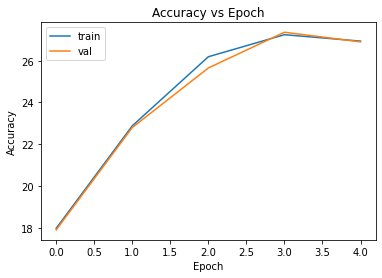

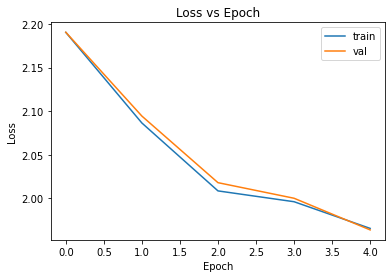

end time  2022-10-27 02:24:12.822964
513.549384
end time  2022-10-27 02:24:12.823261
513.549681


In [ ]:

# Experiment for dropout to limit overfitting
start_time = datetime.datetime.now()
print("start time ", start_time)

lr_results = []
epoch_number = 5
for lr in [0.002]:
    print('learning rate is ', lr)
    # your code here  
    criterion = nn.CrossEntropyLoss()

    cnn_network_with_three_conv_and_one_fc_batch_norm = CnnNetworkThreeConvAndOneFcAndBatchNormAndDropout(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
    cnn_network_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.to(get_device())

    train_results_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.train_network(epoch_number = epoch_number, 
        learning_rate = lr, momentum = 0.9, optimizer_name = "sgd")
    cnn_network_with_three_conv_and_one_fc_batch_norm.plot_loss_and_accuracy_curves()
    
    end_time =  datetime.datetime.now()
    print("end time ", end_time)
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    print(difference_total_seconds)

    last_train_data = [td for td in train_results_with_three_conv_and_one_fc_batch_norm if td['epoch'] == epoch_number - 1][0]
   
    lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)


start time  2022-10-27 04:17:08.451253
learning rate is  0.002
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 2.0972897211432455, 'train_accuracy': 21.0625, 'val_loss': 2.0951491460323335, 'val_accuracy': 21.53}
Train result  {'epoch': 1, 'train_loss': 1.4910248160347344, 'train_accuracy': 45.4425, 'val_loss': 1.501414831864834, 'val_accuracy': 44.81}
Train result  {'epoch': 2, 'train_loss': 1.3926304421685636, 'train_accuracy': 50.38, 'val_loss': 1.4005163181662559, 'val_accuracy': 49.92}
Train result  {'epoch': 3, 'train_loss': 1.3207488838844001, 'train_accuracy': 51.81, 'val_loss': 1.3375477895140648, 'val_accuracy': 51.59}
Train result  {'epoch': 4, 'train_loss': 1.250080327091366, 'train_accuracy': 54.6875, 'val_loss': 1.2791757298603654, 'val_accuracy': 54.1}
Train result  {'epoch': 5, 'train_loss': 1.20437256

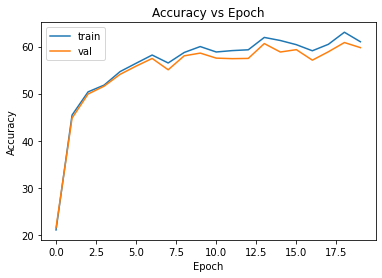

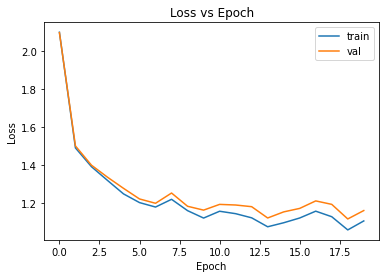

end time  2022-10-27 04:48:57.200710
1908.749457
end time  2022-10-27 04:48:57.201008
1908.749755


In [ ]:

# Experiment for dropout to limit overfitting
start_time = datetime.datetime.now()
print("start time ", start_time)

lr_results = []
epoch_number = 20
for lr in [0.002]:
    print('learning rate is ', lr)
    # your code here  
    criterion = nn.CrossEntropyLoss()

    cnn_network_with_three_conv_and_one_fc_batch_norm = CnnNetworkThreeConvAndOneFcAndBatchNormAndDropout(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
    cnn_network_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.to(get_device())

    train_results_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.train_network(epoch_number = epoch_number, 
        learning_rate = lr, momentum = 0.9, optimizer_name = "sgd")
    cnn_network_with_three_conv_and_one_fc_batch_norm.plot_loss_and_accuracy_curves()
    
    end_time =  datetime.datetime.now()
    print("end time ", end_time)
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    print(difference_total_seconds)

    last_train_data = [td for td in train_results_with_three_conv_and_one_fc_batch_norm if td['epoch'] == epoch_number - 1][0]
   
    lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)


start time  2022-10-27 04:55:02.386544
learning rate is  0.001
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 1.9089267289102076, 'train_accuracy': 29.955, 'val_loss': 1.9112209158420563, 'val_accuracy': 29.63}
Train result  {'epoch': 1, 'train_loss': 1.4161678093507886, 'train_accuracy': 48.1175, 'val_loss': 1.4188289575278759, 'val_accuracy': 48.56}
Train result  {'epoch': 2, 'train_loss': 1.3223348721608519, 'train_accuracy': 52.59, 'val_loss': 1.3338247717738152, 'val_accuracy': 51.55}
Train result  {'epoch': 3, 'train_loss': 1.2166843471333384, 'train_accuracy': 55.915, 'val_loss': 1.2418543306708336, 'val_accuracy': 54.55}
Train result  {'epoch': 4, 'train_loss': 1.1900141730703413, 'train_accuracy': 57.27, 'val_loss': 1.2151659506320953, 'val_accuracy': 56.39}
Train result  {'epoch': 5, 'train_loss': 1.1489858

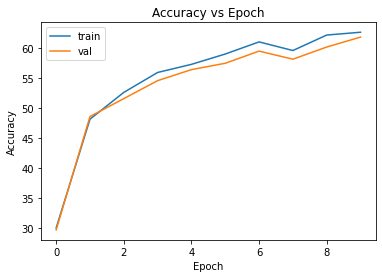

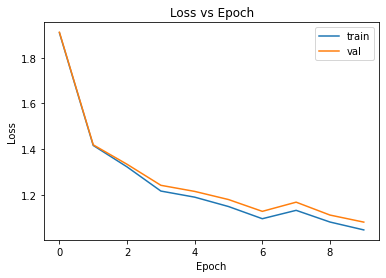

end time  2022-10-27 05:11:02.551617
960.165073
learning rate is  0.0001
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 1.8986892531573771, 'train_accuracy': 31.12, 'val_loss': 1.9049106996536256, 'val_accuracy': 30.89}
Train result  {'epoch': 1, 'train_loss': 1.5332264673471452, 'train_accuracy': 43.6775, 'val_loss': 1.5386336847543716, 'val_accuracy': 42.62}
Train result  {'epoch': 2, 'train_loss': 1.4125107045441867, 'train_accuracy': 48.4275, 'val_loss': 1.4179544102430344, 'val_accuracy': 48.22}
Train result  {'epoch': 3, 'train_loss': 1.309930987496674, 'train_accuracy': 52.485, 'val_loss': 1.3175976223528385, 'val_accuracy': 51.93}
Train result  {'epoch': 4, 'train_loss': 1.2749600019350649, 'train_accuracy': 54.0625, 'val_loss': 1.2922566634982824, 'val_accuracy': 53.36}
Train result  {'epoch': 5, 'train_loss

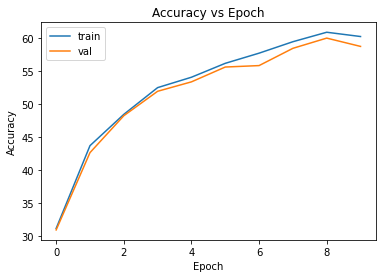

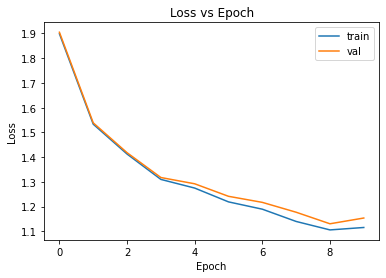

end time  2022-10-27 05:26:55.646814
1913.26027
end time  2022-10-27 05:26:55.647112
1913.260568


In [ ]:

# Experiment for dropout to limit overfitting
start_time = datetime.datetime.now()
print("start time ", start_time)

lr_results = []
epoch_number = 10
for lr in [0.001, 0.0001]:
    print('learning rate is ', lr)
    # your code here  
    criterion = nn.CrossEntropyLoss()

    cnn_network_with_three_conv_and_one_fc_batch_norm = CnnNetworkThreeConvAndOneFcAndBatchNormAndDropout(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
    cnn_network_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.to(get_device())

    train_results_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.train_network(epoch_number = epoch_number, 
        learning_rate = lr, momentum = 0.9, optimizer_name = "sgd")
    cnn_network_with_three_conv_and_one_fc_batch_norm.plot_loss_and_accuracy_curves()
    
    end_time =  datetime.datetime.now()
    print("end time ", end_time)
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    print(difference_total_seconds)

    last_train_data = [td for td in train_results_with_three_conv_and_one_fc_batch_norm if td['epoch'] == epoch_number - 1][0]
   
    lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)


start time  2022-10-27 10:28:02.149869
learning rate is  0.001
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 2.0692343001246454, 'train_accuracy': 25.12, 'val_loss': 2.074413657474518, 'val_accuracy': 24.75}
Train result  {'epoch': 1, 'train_loss': 1.572767790451646, 'train_accuracy': 43.61, 'val_loss': 1.5766544608712196, 'val_accuracy': 43.58}
Train result  {'epoch': 2, 'train_loss': 1.6052220261365175, 'train_accuracy': 44.1125, 'val_loss': 1.6114120808362962, 'val_accuracy': 43.98}
Train result  {'epoch': 3, 'train_loss': 1.3578244447529315, 'train_accuracy': 51.7575, 'val_loss': 1.3596809985518457, 'val_accuracy': 52.05}
Train result  {'epoch': 4, 'train_loss': 1.3473608272798359, 'train_accuracy': 52.175, 'val_loss': 1.3614051684767008, 'val_accuracy': 51.28}
Train result  {'epoch': 5, 'train_loss': 1.26263352

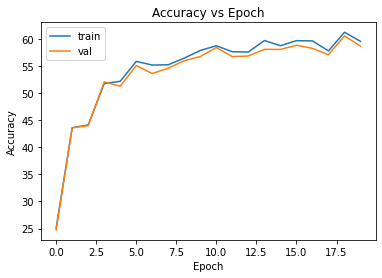

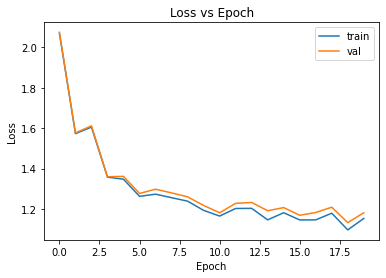

Test Accuracy  58.07
Test Loss  1.2023071736365556
end time  2022-10-27 11:02:43.792046
2081.642177
end time  2022-10-27 11:02:43.792394
2081.642525


In [17]:

# Experiment for more epochs 20 with lr 0.001, because chances of improvement
start_time = datetime.datetime.now()
print("start time ", start_time)

lr_results = []
epoch_number = 20
for lr in [0.001]:
    print('learning rate is ', lr)
    # your code here  
    criterion = nn.CrossEntropyLoss()

    cnn_network_with_three_conv_and_one_fc_batch_norm = CnnNetworkThreeConvAndOneFcAndBatchNormAndDropout(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
    cnn_network_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.to(get_device())

    train_results_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.train_network(epoch_number = epoch_number, 
        learning_rate = lr, momentum = 0.9, optimizer_name = "sgd")
    cnn_network_with_three_conv_and_one_fc_batch_norm.plot_loss_and_accuracy_curves()
    
    test_accuracy, test_loss = cnn_network_with_three_conv_and_one_fc_batch_norm.get_accuracy_and_loss(cnn_network_with_three_conv_and_one_fc_batch_norm.testloader)
    print('Test Accuracy ', test_accuracy)
    print('Test Loss ', test_loss)

    end_time =  datetime.datetime.now()
    print("end time ", end_time)
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    print(difference_total_seconds)

    last_train_data = [td for td in train_results_with_three_conv_and_one_fc_batch_norm if td['epoch'] == epoch_number - 1][0]
    
    lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)


start time  2022-10-27 10:08:04.027517
learning rate is  0.001
Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 2.0445553248882296, 'train_accuracy': 26.2875, 'val_loss': 2.049584948396683, 'val_accuracy': 25.41}
Train result  {'epoch': 1, 'train_loss': 1.5680149745762348, 'train_accuracy': 43.1875, 'val_loss': 1.5807806551933288, 'val_accuracy': 43.63}
Train result  {'epoch': 2, 'train_loss': 1.5077098389908672, 'train_accuracy': 46.565, 'val_loss': 1.519498277056217, 'val_accuracy': 46.38}
Train result  {'epoch': 3, 'train_loss': 1.3650472764879464, 'train_accuracy': 51.5525, 'val_loss': 1.382662204438448, 'val_accuracy': 50.78}
Train result  {'epoch': 4, 'train_loss': 1.3067499410547316, 'train_accuracy': 53.7225, 'val_loss': 1.321062970045209, 'val_accuracy': 52.64}
Finished Training


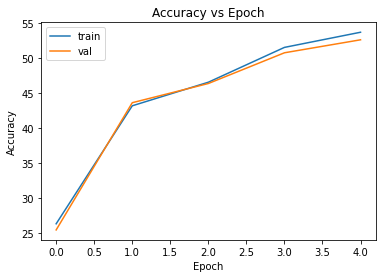

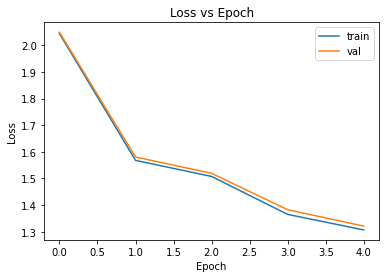

Test Accuracy  52.26
Test Loss  1.3341343573570252
end time  2022-10-27 10:17:07.177386
543.149869
end time  2022-10-27 10:17:07.177719
543.150202


In [16]:

# Experiment for more epochs 5 with lr 0.001, for comparision with pretrained
start_time = datetime.datetime.now()
print("start time ", start_time)

lr_results = []
epoch_number = 5
for lr in [0.001]:
    print('learning rate is ', lr)
    # your code here  
    criterion = nn.CrossEntropyLoss()

    cnn_network_with_three_conv_and_one_fc_batch_norm = CnnNetworkThreeConvAndOneFcAndBatchNormAndDropout(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                        train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
    cnn_network_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.to(get_device())

    train_results_with_three_conv_and_one_fc_batch_norm = cnn_network_with_three_conv_and_one_fc_batch_norm.train_network(epoch_number = epoch_number, 
        learning_rate = lr, momentum = 0.9, optimizer_name = "sgd")
    cnn_network_with_three_conv_and_one_fc_batch_norm.plot_loss_and_accuracy_curves()

    test_accuracy, test_loss = cnn_network_with_three_conv_and_one_fc_batch_norm.get_accuracy_and_loss(cnn_network_with_three_conv_and_one_fc_batch_norm.testloader)
    print('Test Accuracy ', test_accuracy)
    print('Test Loss ', test_loss)
    
    end_time =  datetime.datetime.now()
    print("end time ", end_time)
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    print(difference_total_seconds)

    last_train_data = [td for td in train_results_with_three_conv_and_one_fc_batch_norm if td['epoch'] == epoch_number - 1][0]
    
    lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)


In [ ]:
# # Add Another conv layer
# class CnnNetworkTwoConvAndOneFcAndOneBatchNormInSecondConv(NetworkBase):
#     def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size = 32, print_interim_data_shapes = False):
#         super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size, print_interim_data_shapes)
#         self.criterion = criterion
#         self.conv1 = nn.Conv2d(3, 32, 3)
#         self.conv1_bn = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, 3)
#         self.conv2_bn = nn.BatchNorm2d(64)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(64 * 6 * 6, 10)
       
#     def forward(self, x):
#         if self.print_interim_data_shapes:
#             print("Initial x shape ", x.shape)
       
#         # First layer
#         x = self.conv1(x)
#         x = self.conv1_bn(x)
#         x = F.relu(x)
#         if self.print_interim_data_shapes:
#             print('After conv1, shape of x is ', x.shape)
#         x = self.pool(x)
#         if self.print_interim_data_shapes:
#             print('After max pool 1, shape of x is ', x.shape)

#         # second layer
#         x = self.conv2(x)
#         if self.print_interim_data_shapes:
#             print('After conv2, shape of x is ', x.shape)
#         x = self.conv2_bn(x)
#         x = F.relu(x)
        
#         if self.print_interim_data_shapes:
#             print('After conv2 batch norm, shape of x is ', x.shape)
#         x = self.pool(x)
#         if self.print_interim_data_shapes:
#             print('After max pool 2, shape of x is ', x.shape)
        
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         if self.print_interim_data_shapes:
#             print('After flatten, x shape ', x.shape)

#         x = self.fc1(x)
#         if self.print_interim_data_shapes:
#             print('At End, x shape ', x.shape)
#             break_here_to_see_shapes_for_first_iter
#         return x



In [ ]:
# # Experiment two Convolution layer (32 3*3 filters) and One Fully Connected Layer and one batch norm at second layer
# start_time = datetime.datetime.now()
# print("start time ", start_time)
# # sleep in seconds
# time.sleep(1)

# lr_results = []
# epoch_number = 5
# for lr in [0.001]:
#     print('learning rate is ', lr)
#     # your code here  
#     criterion = nn.CrossEntropyLoss()

#     cnn_network_with_two_conv_and_one_fc_and_batch_norm = CnnNetworkTwoConvAndOneFcAndOneBatchNormInSecondConv(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
#                         train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
#     cnn_network_with_two_conv_and_one_fc_and_batch_norm = cnn_network_with_two_conv_and_one_fc_and_batch_norm.to(get_device())

#     train_results_with_two_conv_and_one_fc_one_bn = cnn_network_with_two_conv_and_one_fc_and_batch_norm.train(epoch_number = epoch_number, 
#         learning_rate = lr, momentum = 0.9, optimizer_name = "sgd")
#     cnn_network_with_two_conv_and_one_fc_and_batch_norm.plot_loss_and_accuracy_curves()
    
#     end_time =  datetime.datetime.now()
#     print("end time ", end_time)
#     difference = end_time - start_time
#     difference_total_seconds = difference.total_seconds()
#     print(difference_total_seconds)

#     last_train_data = [td for td in train_results_with_two_conv_and_one_fc_one_bn if td['epoch'] == epoch_number - 1][0]
   
#     lr_results.append({'learning_rate': lr, 'val_loss': last_train_data['val_loss'], 'val_accuracy': last_train_data['val_accuracy']})


# end_time =  datetime.datetime.now()
# print("end time ", end_time)
# difference = end_time - start_time
# difference_total_seconds = difference.total_seconds()
# print(difference_total_seconds)


In [ ]:
# class CnnNetwork(NetworkBase):
#     def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size = 32, print_interim_data_shapes = False):
#         super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size, print_interim_data_shapes)
#         self.criterion = criterion
#         # input channel should be 3 for color image and 1 for grayscale
#         self.conv1 = nn.Conv2d(3, 6, 3)
#         # https://discuss.pytorch.org/t/example-on-how-to-use-batch-norm/216
#         self.conv1_bn = nn.BatchNorm2d(6)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.conv2_bn = nn.BatchNorm2d(16)
#         # mat1 and mat2 shapes cannot be multiplied (4x576 and 400x120)
#         # filter = 1, input shape for linear should be 6 * 6,
#         # filter = 3, 5, input shape for linear should be 5 * 5
#         self.fc1 = nn.Linear(16 * 6 * 6, 120)
#         # self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc1_bn = nn.BatchNorm1d(120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#         self.softmax = nn.Softmax(1)
#         self.dropout_2d = nn.Dropout2d()
#         self.dropout_1d = nn.Dropout1d()

#     def forward(self, x):
#         if self.print_interim_data_shapes:
#             print("Initial x shape ", x.shape)
#         # x = self.pool(F.relu(self.conv1(x)))
#         # print("After conv1 and maxpool, x shape ", x.shape)

#         # First layer
#         x = self.conv1(x)
#         # x = self.conv1_bn(x)
#         x = F.relu(x)
#         if self.print_interim_data_shapes:
#             print('After conv1, shape of x is ', x.shape)
#         x = self.pool(x)
#         if self.print_interim_data_shapes:
#             print('After max pool 1, shape of x is ', x.shape)
        
#         # dropout
#         # x = self.dropout_2d(x)
#         if self.print_interim_data_shapes:
#             print('Shape after dropout after conv layer 1 ', x.shape) 
#         # Second layer
#         # x = self.pool(F.relu(self.conv2(x)))
#         # print("After conv2 and maxpool, x shape ", x.shape)

#         x = self.conv2(x)
#         # x = self.conv2_bn(x)
#         x = F.relu(x)
#         if self.print_interim_data_shapes:
#             print('After conv2, shape of X is ', x.shape)
#         x = self.pool(x)
#         if self.print_interim_data_shapes:
#             print('After max pool 2, shape of x is ', x.shape)

#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         if self.print_interim_data_shapes:
#             print('After flatten, x shape ', x.shape)

#         x = self.fc1(x)
#         # x = self.fc1_bn(x)
#         x = F.relu(x)
#         if self.print_interim_data_shapes:
#             print('After fc1, x shape ', x.shape)

#         x = self.fc2(x)
#         x = F.relu(x)
#         if self.print_interim_data_shapes:
#             print('After fc2, x shape ', x.shape)
#         x = self.fc3(x)
#         if self.print_interim_data_shapes:
#             print('After fc3, x shape ', x.shape)
#             # break_here_i_want_to_see_shapes
#         # x = self.softmax(x)
        
#         return x



In [ ]:

# criterion = nn.CrossEntropyLoss()

# cnn_network = CnnNetwork(data_set_name = "cifar_10", batch_size = 32, download_path = "./data", 
#                      train_data_size = 40000, validation_data_size = 10000, criterion = criterion, print_interim_data_shapes = False)
# cnn_network = cnn_network.to(get_device())

# train_results = cnn_network.train(epoch_number = 2, learning_rate = 0.001, momentum = 0.9, optimizer_name = "sgd")
# cnn_network.plot_loss_and_accuracy_curves()
# # print(train_results)
# test_accuracy, test_loss = cnn_network.get_accuracy_and_loss(cnn_network.testloader)
# print('Test Accuracy ', test_accuracy)
# print('Test Loss ', test_loss)

In [ ]:
# from torchvision import models
# alexnet = models.alexnet(pretrained=True)
# print(alexnet)

In [ ]:
from torchvision import models
# mobilenetv2 = models.mobilenet_v2(pretrained=True)
# print(mobilenetv2)
from torchvision.models import MobileNet_V2_Weights
print(MobileNet_V2_Weights.DEFAULT.transforms())

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Num feat  1280
Train result  {'epoch': 0, 'train_loss': 0.3164950348464401, 'train_accuracy': 89.5625, 'val_loss': 0.3681277444595296, 'val_accuracy': 87.4}
Train result  {'epoch': 1, 'train_loss': 0.6125405733361724, 'train_accuracy': 79.585, 'val_loss': 0.6456314674585591, 'val_accuracy': 78.23}
Train result  {'epoch': 2, 'train_loss': 0.37298471185036614, 'train_accuracy': 87.2375, 'val_loss': 0.44830643585460495, 'val_accuracy': 85.08}
Train result  {'epoch': 3, 'train_loss': 0.3379590835896903, 'train_accuracy': 88.4325, 'val_loss': 0.44622713229712174, 'val_accuracy': 85.25}
Train result  {'epoch': 4, 'train_loss': 0.2808565056297779, 'train_accuracy': 90.25, 'val_loss': 0.38139433456762634, 'val_accuracy': 87.0}
Finished Training


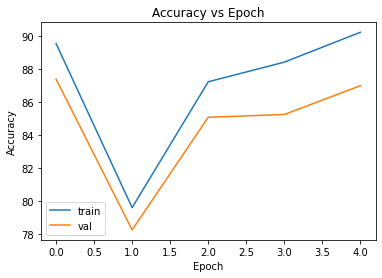

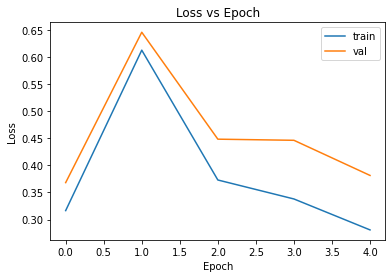

Test Accuracy  86.81
Test Loss  0.39313048650025884


In [ ]:
class CnnMobileNet(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size = 224)
        self.network = models.mobilenet_v2(pretrained=True)
        num = 1
        num_ftrs = self.network.classifier[num].in_features
        print('Num feat ',num_ftrs)
        self.network.classifier[num]= torch.nn.Linear(num_ftrs,10)
        self.criterion = criterion

    def forward(self, x):
        return self.network(x) 

criterion = nn.CrossEntropyLoss()

cnn_network = CnnMobileNet(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
cnn_network = cnn_network.to(get_device())

train_results = cnn_network.train_network(epoch_number = 5, learning_rate = 0.001, momentum = 0.9, optimizer_name = "sgd")
cnn_network.plot_loss_and_accuracy_curves()
# print(train_results)
test_accuracy, test_loss = cnn_network.get_accuracy_and_loss(cnn_network.testloader)
print('Test Accuracy ', test_accuracy)
print('Test Loss ', test_loss)

In [ ]:
# class CnnMobileNet(NetworkBase):
#     def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
#         super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion)
#         self.network = models.mobilenet_v2(pretrained=False)
#         num = 1
#         num_ftrs = self.network.classifier[num].in_features
#         print('Num feat ',num_ftrs)
#         self.network.classifier[num]= torch.nn.Linear(num_ftrs,10)
#         self.criterion = criterion

#     def forward(self, x):
#         return self.network(x) 

# criterion = nn.CrossEntropyLoss()

# cnn_network = CnnMobileNet(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
#                      train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
# cnn_network = cnn_network.to(get_device())

# train_results = cnn_network.train(epoch_number = 2, learning_rate = 0.001, momentum = 0.9, optimizer_name = "sgd")
# cnn_network.plot_loss_and_accuracy_curves()
# # print(train_results)
# test_accuracy, test_loss = cnn_network.get_accuracy_and_loss(cnn_network.testloader)
# print('Test Accuracy ', test_accuracy)
# print('Test Loss ', test_loss)

Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Num feat  4096
Train result  {'epoch': 0, 'train_loss': 0.48564324715129914, 'train_accuracy': 83.9075, 'val_loss': 0.5801656898946036, 'val_accuracy': 80.73}
Train result  {'epoch': 1, 'train_loss': 0.2603162124826572, 'train_accuracy': 91.11, 'val_loss': 0.44456176054739044, 'val_accuracy': 84.68}
Train result  {'epoch': 2, 'train_loss': 0.15135204271199723, 'train_accuracy': 95.0825, 'val_loss': 0.41165848978243796, 'val_accuracy': 86.35}
Train result  {'epoch': 3, 'train_loss': 0.13355390292099106, 'train_accuracy': 95.6825, 'val_loss': 0.45174523051236104, 'val_accuracy': 85.64}
Train result  {'epoch': 4, 'train_loss': 0.16277833987388649, 'train_accuracy': 94.385, 'val_loss': 0.6144343603356757, 'val_accuracy': 82.78}
Finished Training


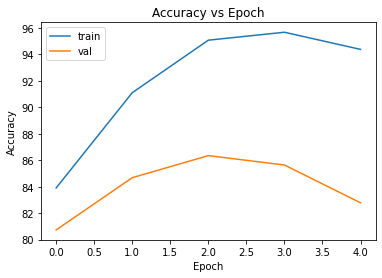

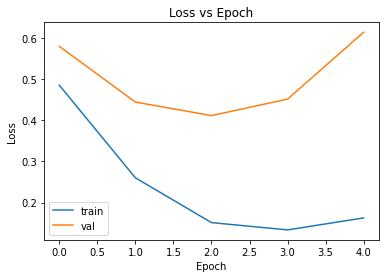

Test Accuracy  83.2
Test Loss  0.6027178319410241


In [ ]:
class CnnAlexNet(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size=224)
        self.network = models.alexnet(pretrained=True)
        num = 6
        num_ftrs = self.network.classifier[num].in_features
        print('Num feat ',num_ftrs)
        # self.network.classifier[4]= torch.nn.Linear(4096,512)
        self.network.classifier[6]= torch.nn.Linear(num_ftrs,10)
        # (6): Linear(in_features=4096, out_features=1000, bias=True)
        self.criterion = criterion

    def forward(self, x):
        return self.network(x) 

criterion = nn.CrossEntropyLoss()

cnn_network = CnnAlexNet(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
cnn_network = cnn_network.to(get_device())

train_results = cnn_network.train_network(epoch_number = 5, learning_rate = 0.001, momentum = 0.9, optimizer_name = "sgd")
cnn_network.plot_loss_and_accuracy_curves()
# print(train_results)
test_accuracy, test_loss = cnn_network.get_accuracy_and_loss(cnn_network.testloader)
print('Test Accuracy ', test_accuracy)
print('Test Loss ', test_loss)

In [ ]:
# from torchvision import models
# resnet = models.resnet18(pretrained=True)
# print(resnet)

Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Num feat  512
Train result  {'epoch': 0, 'train_loss': 0.2368031624655604, 'train_accuracy': 92.1625, 'val_loss': 0.3225336252158311, 'val_accuracy': 89.29}
Train result  {'epoch': 1, 'train_loss': 0.19977364148455135, 'train_accuracy': 93.5775, 'val_loss': 0.3071121104089898, 'val_accuracy': 89.51}
Train result  {'epoch': 2, 'train_loss': 0.1446181307222479, 'train_accuracy': 94.9375, 'val_loss': 0.28167152370054194, 'val_accuracy': 90.24}
Train result  {'epoch': 3, 'train_loss': 0.0816418649947008, 'train_accuracy': 97.61, 'val_loss': 0.24660910491374516, 'val_accuracy': 91.86}
Train result  {'epoch': 4, 'train_loss': 0.2864134748794695, 'train_accuracy': 90.7125, 'val_loss': 0.5762750855294697, 'val_accuracy': 84.5}
Finished Training


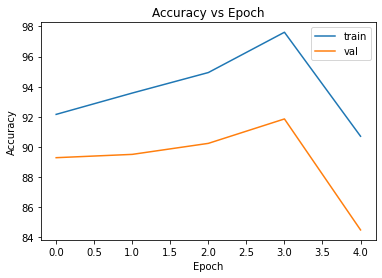

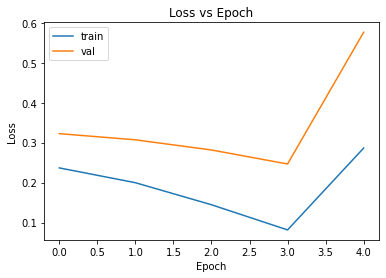

Test Accuracy  84.41
Test Loss  0.5564842904207521


In [ ]:
class CnnResNet18(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size=224)
        self.network = models.resnet18(pretrained=True)
        # num = 6
        num_ftrs = self.network.fc.in_features
        print('Num feat ',num_ftrs)
        # self.network.classifier[4]= torch.nn.Linear(4096,512)
        self.network.fc= torch.nn.Linear(num_ftrs,10)
        # (6): Linear(in_features=4096, out_features=1000, bias=True)
        self.criterion = criterion

    def forward(self, x):
        return self.network(x) 

criterion = nn.CrossEntropyLoss()

cnn_network = CnnResNet18(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
cnn_network = cnn_network.to(get_device())

train_results = cnn_network.train_network(epoch_number = 5, learning_rate = 0.001, momentum = 0.9, optimizer_name = "sgd")
cnn_network.plot_loss_and_accuracy_curves()
# print(train_results)
test_accuracy, test_loss = cnn_network.get_accuracy_and_loss(cnn_network.testloader)
print('Test Accuracy ', test_accuracy)
print('Test Loss ', test_loss)

In [ ]:
# from torchvision import models
# resnet = models.resnet101(pretrained=True)
# print(resnet)

In [ ]:
class CnnResNet101(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size=224)
        self.network = models.resnet101(pretrained=True)
        # num = 6
        num_ftrs = self.network.fc.in_features
        print('Num feat ',num_ftrs)
        # self.network.classifier[4]= torch.nn.Linear(4096,512)
        self.network.fc= torch.nn.Linear(num_ftrs,10)
        # (6): Linear(in_features=4096, out_features=1000, bias=True)
        self.criterion = criterion

    def forward(self, x):
        return self.network(x) 

In [ ]:
class CnnResNet101(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size=224)
        self.network = models.resnet101(pretrained=True)
        # num = 6
        num_ftrs = self.network.fc.in_features
        print('Num feat ',num_ftrs)
        # self.network.classifier[4]= torch.nn.Linear(4096,512)
        self.network.fc= torch.nn.Linear(num_ftrs,10)
        # (6): Linear(in_features=4096, out_features=1000, bias=True)
        self.criterion = criterion

    def forward(self, x):
        return self.network(x) 

criterion = nn.CrossEntropyLoss()

cnn_network = CnnResNet101(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
cnn_network = cnn_network.to(get_device())

train_results = cnn_network.train_network(epoch_number = 5, learning_rate = 0.001, momentum = 0.9, optimizer_name = "sgd")
cnn_network.plot_loss_and_accuracy_curves()
# print(train_results)
test_accuracy, test_loss = cnn_network.get_accuracy_and_loss(cnn_network.testloader)
print('Test Accuracy ', test_accuracy)
print('Test Loss ', test_loss)

In [ ]:
# Experiments
# Pre processing: Convert into grayscale, since our objective is classification, we don't need  color too,
# try with grayscale image
# Post processing: pooling: Max pooling, average pooling, min pooling. But, practically, max pooling was found to be better by many researchers


# selecting the model
# CNN Architectures (How to choose CNN architecture ????) #Ans: intuitive
#   Number of Layers ??
# Batch Normalization : CNN, FC
# Dropout: for small network, the accuracy decreased, not so good

# Standard Architectures: AlexNet, GoogleNet, VGGNet, ResNet,  MobileNet..
# AlexNet, ResNet..
# Input data enhancements
# Data augmentation

# Hyper parameters
# Loss
# Optimizer
# Learning rate
# Batch size
# Epoch

# even if input size changes, it impacts performance, accuracy

# check what model.train and model.eval does in pytorch
# check reduceLROnPlateau
# FLOP counts : operations count
# use pretrained

# get time required to train for every experiment


In [ ]:
import datetime
import time
start_time = datetime.datetime.now()
print("start time ", start_time)
# sleep in seconds
time.sleep(1)

# your code here  

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)

start time  2022-10-24 08:26:06.748863
end time  2022-10-24 08:26:07.750783
1.00192


In [ ]:
# FLOP
#The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
#Download the code.
!wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
!mv download FLOPs_counter.py
#!rm -rf download



--2022-10-24 08:02:21--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=coabi26k672okkp9lep40bcr6v; path=/plus;; Secure at position 53.
Syntax error in Set-Cookie: oc_sessionPassphrase=g937oyo%2FP9TlRksjzEA7ke2XdAgggIfUXAjbL9KFa3Cnf7YjO7hYxDyp8Ka7ton5Yuc3z5AxQHZgJo2MdpQZVNbj7PfrY8rVflQBeWM3jYatn8r4gV%2BTRPJmRRHfQYzg; expires=Tue, 25-Oct-2022 08:02:22 GMT; Max-Age=86400; path=/plus;; Secure at position 220.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2022-10-24 08:02:22 (518 MB/s) - ‘download’ saved [5201/5201]



In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1,3,32,32)
criterion = nn.CrossEntropyLoss()
cnn_network = CnnNetwork(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion, image_size=32)
print_model_parm_flops(cnn_network, input, detail=True)

Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
 + Number of FLOPs: 0.00G


In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1,3,224,224)
criterion = nn.CrossEntropyLoss()
cnn_network = CnnResNet101(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
print_model_parm_flops(cnn_network, input, detail=True)

Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Num feat  2048
 + Number of FLOPs: 15.61G
